In [1]:
# data wrangling
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt

# other
import time

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
#^https://scikit-learn.org/stable/modules/neural_networks_supervised.html^

In [2]:
DATA_FILEPATH = "../data/all_hourly_data.h5"
patients = pd.read_hdf(DATA_FILEPATH, "patients")
vitals_labs_mean = pd.read_hdf(DATA_FILEPATH, "vitals_labs_mean")
interventions = pd.read_hdf(DATA_FILEPATH, "interventions")

In [3]:
"""
Task Formulation: predict whether a patient will die, given the first 24 hours of their stay
"""

# SETTINGS
window_size = 24  # the first WINDOW_SIZE hours of the patient's stay
gap_time = 6  # the number of hours the patient lived at least after the first WINDOW_SIZE hours (to avoid label leakage, see MIMIC-III Extract paper)
test_size = 0.2  # proportion of the data that wil lbe used for testing
val_size = 0.125  # proportion of the training data that will be used for validation
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.8  # maximum percentage of missing values after forward fill for a measurement to be dropped

In [4]:
patients_intermediate = pd.DataFrame();

for i in range(10):
    patients_intermediate = pd.concat([patients_intermediate, patients.groupby('mort_icu', group_keys=False).apply(lambda x: x.sample(1000))])
print(patients_intermediate["mort_icu"].value_counts())

0    10000
1    10000
Name: mort_icu, dtype: int64


In [5]:
start_time = time.time()

"""PREPARE VITALS LABES AND INTERVENTIONS"""
# select first 24 hours of patient data for ICU stays of selected patients
X = vitals_labs_mean.droplevel(
    level="Aggregation Function", axis=1
).copy()  # drop constant 'mean' level
X = X.join(interventions)  # add interventions
X = X[
    (
        X.index.get_level_values("icustay_id").isin(
            set(patients_intermediate["mort_icu"].index.get_level_values("icustay_id"))
        )
    )
    & (X.index.get_level_values("hours_in") < 24)
]

# reset index so only subject_id is in index
# y = y.reset_index(level=["hadm_id", "icustay_id"], drop=True)
X = X.reset_index(level=["hadm_id", "icustay_id"], drop=True).unstack()

X = X.groupby(level=["subject_id"]).cumsum()


"""SPLIT DATA"""
# define train/test split based on index
X_train_r, X_test_r = train_test_split(
    X, test_size=test_size, random_state=random_state
)
X_train_r, X_val_r = train_test_split(
    X_train_r, test_size=val_size, random_state=random_state
)

"""IMPUTE MISSING VALUES"""
# compute mean and std of raw values
mean = X_train_r.stack().mean(axis=0)
std = X_train_r.stack().std(axis=0)

# forward fill missing values
X_train = X_train_r.copy().stack(dropna=False).groupby("subject_id").ffill()
X_test = X_test_r.copy().stack(dropna=False).groupby("subject_id").ffill()
X_val = X_val_r.copy().stack(dropna=False).groupby("subject_id").ffill()

# remove features with too many missing values
missing = X_train.isna().sum() > max_missing * len(X_train)
missing = missing[missing].index
X_train = X_train.drop(missing, axis=1)
X_val = X_val.drop(missing, axis=1)
X_test = X_test.drop(missing, axis=1)

# impute remaining missing values with the mean of original data and get to hourly
means = X_train_r.stack().mean(
    axis=0
)  # get average of hourly measurement value for each feature
X_train = X_train.fillna(means).unstack()
X_test = X_test.fillna(means).unstack()
X_val = X_val.fillna(means).unstack()

"""ADD DEMOGRAPHICS"""
# convert gender to boolean feature
demo = pd.get_dummies(patients_intermediate[["gender"]], drop_first=True)
demo["mort_icu"] = patients_intermediate["mort_icu"]


# replace age of people older than 89 by 90
demo["age"] = patients_intermediate["age"]
demo.loc[demo[demo["age"] >= 90].index, "age"] = 90

# create ethnicity columns
demo["white"] = patients_intermediate["ethnicity"].str.contains("WHITE")
demo["black"] = patients_intermediate["ethnicity"].str.contains("BLACK")
demo["asian"] = patients_intermediate["ethnicity"].str.contains("ASIAN")
demo["hispanic"] = patients_intermediate["ethnicity"].str.contains("HISPANIC")
demo["other/unknown"] = ~(
    demo["white"] | demo["black"] | demo["asian"] | demo["hispanic"]
)

# reset index to remove icu id and hadm id
demo = demo.reset_index(level=[1, 2], drop=True)
demo.columns = pd.MultiIndex.from_product([demo.columns, [-1]])

# add demographics to dataframes
X_train = X_train.join(demo)
X_val = X_val.join(demo)
X_test = X_test.join(demo)

# combine column levels
X_train.columns = X_train.columns.map('{0[0]}|{0[1]}'.format)
X_val.columns = X_val.columns.map('{0[0]}|{0[1]}'.format)
X_test.columns = X_test.columns.map('{0[0]}|{0[1]}'.format)

# reset index once more
X_train.reset_index(inplace = True, drop = True)
X_val.reset_index(inplace = True, drop = True)
X_test.reset_index(inplace = True, drop = True)

# get y variables
y_train = X_train["mort_icu|-1"]
y_val = X_val["mort_icu|-1"]
y_test = X_test["mort_icu|-1"]

X_train.drop('mort_icu|-1', axis=1, inplace=True)
X_val.drop('mort_icu|-1', axis=1, inplace=True)
X_test.drop('mort_icu|-1', axis=1, inplace=True)

X_train[X_train.select_dtypes(bool).columns] = X_train.select_dtypes(bool).astype(np.float64)
X_val[X_val.select_dtypes(bool).columns] = X_val.select_dtypes(bool).astype(np.float64)
X_test[X_test.select_dtypes(bool).columns] = X_test.select_dtypes(bool).astype(np.float64)

"""RESET INDEX"""
y_train = y_train.reindex(X_train.index)
y_test = y_test.reindex(X_test.index)
y_val = y_val.reindex(X_val.index)

"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

Time: 11.19s
Train set: 13959 rows, 1903 columns
Validation set: 2033 rows, 1903 columns
Test set: 4008 rows, 1903 columns


In [6]:
def TP(y_true, y_pred):
    return np.sum(np.logical_and(y_true == 1.0, y_pred == 1.0))

def FP(y_true, y_pred):
    return np.sum(np.logical_and(y_true == 0.0, y_pred == 1.0))

def FN(y_true, y_pred):
    return np.sum(np.logical_and(y_true == 1.0, y_pred == 0.0))

def TN(y_true, y_pred):
    return np.sum(np.logical_and(y_true == 0.0, y_pred == 0.0))

def TPR(y_true, y_pred):
    return TP(y_true, y_pred)/(TP(y_true, y_pred) + FN(y_true, y_pred))

def FPR(y_true, y_pred):
    return FP(y_true, y_pred)/(FP(y_true, y_pred) + TN(y_true, y_pred))

In [9]:
from sklearn.ensemble import GradientBoostingRegressor


neural_network_classifier = GradientBoostingRegressor()
neural_network_classifier.fit(X_train, y_train)

GradientBoostingRegressor()

In [33]:
y_true = y_val.to_numpy()
y_pred = np.where(neural_network_classifier.predict(X_val) > 0.3, 1, 0)

print("True positives count: " + str(TP(y_true, y_pred)))
print("False positives count: " + str(FP(y_true, y_pred)))
print("False negatives count: " + str(FN(y_true, y_pred)))
print("True negatives count: " + str(TN(y_true, y_pred)))
print("True positive rate: " + str(TPR(y_true, y_pred)))
print("False positive rate: " + str(FPR(y_true, y_pred)))

True positives count: 944
False positives count: 278
False negatives count: 96
True negatives count: 715
True positive rate: 0.9076923076923077
False positive rate: 0.2799597180261833


In [29]:
df_func = pd.DataFrame(columns=['TPR', 'FPR'])
for i in range(0, 101):
    y_pred = np.where(neural_network_classifier.predict(X_val) > i/100, 1, 0)
    df_func.loc[len(df_func)] = [TPR(y_true, y_pred), FPR(y_true, y_pred)]

<AxesSubplot:>

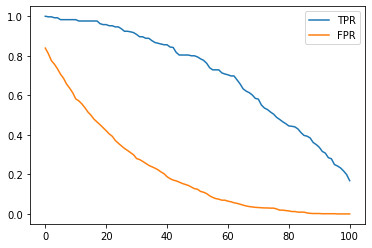

In [30]:
df_func.plot.line()